In [1]:
pip install torch_geometric

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#### run this if using collab

# from google.colab import drive

# drive.mount('/content/drive')

In [4]:
# "/content/drive/MyDrive/Colab Notebooks/GNN/try_networkx_data_training_recruitment.csv"
df = pd.read_csv("try_networkx_data_testing_recruitment.csv")


### Data Preprocessing and Graph Construction

In [5]:
#### constants ######

array_of_skills =  [f'Skill {i}' for i in range(1, 11)]
data_testing_10 = df.head(10)

In [6]:

#create nodes for persons, skills and job
# purpose => extract unique lists of persons, skills, and jobs from dataset
persons = df['ID'].tolist()
skills = list(set(df[array_of_skills].values.flatten()) - {"-"})

# map nodes
# purpose => create dictionaries to map each person, skill and job to unque index
person_idx = {p: i for i, p in enumerate(persons)}
skill_idx = {s: i+len(persons) for i, s in enumerate(skills)}

edges = []

# person to skill edges
for i, row in df.iterrows():
    for skill in array_of_skills:
        if row[skill] != "-":
            # connect each person to their listed skills
            edges.append((person_idx[row["ID"]], skill_idx[row[skill]]))

# convert edges to Pytorch tensors
# purpose convert the list of edges to a PyTorch tensor suitable for PyTorch Geometric
# converts the list of edges to a tensor and transposes it to match the required shape
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()


#create node features (for simplicity, using one-hot encoding for persons and jobs)
num_persons = len(persons)
num_skills = len(skills)
num_nodes = num_persons + num_skills

# creates an identity matrix where each row corresponds to a one-hot encoded vector for a node
x = torch.eye(num_nodes)

# Create PyTorch Geometric Data Object
# purpose => combine the node features and edge indices into a single daa structure used by Pytorch Geometric
data = Data(x=x, edge_index=edge_index)

### Define and Train a GNN Model

In [7]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()

        # GCN layer that reduces the feature size to 16
        # num_nodes from num_persons + num_skills
        self.conv1 = GCNConv(num_nodes, 16)

        # second GCN layer that reduces the feature size to the number oof job categories
        self.conv2 = GCNConv(16, num_skills)

#  define forward pass of the network
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # applies the first GCN layer, followed by ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # applies the second GCN layer
        x = self.conv2(x, edge_index)
        return x

model = GNN()

# adam optimizer to update the model parameters with a leaerning rate of 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
training_losses = []

def train(data, epochs=100):
    model.train()
    target = torch.zeros(num_persons, num_skills)
    for i, row in df.iterrows():
        for skill in array_of_skills:
            if row[skill] != "-":
                target[person_idx[row["ID"]], skill_idx[row[skill]] - len(persons)] = 1


    for epoch in range(epochs):
        # clear the gradients from the previous step
        optimizer.zero_grad()

        # get the model's output for the person nodes
        out = model(data)[:num_persons]

        # calculates the cross-entropy loss between the model's output and the
        # target job indexs
        loss = F.binary_cross_entropy_with_logits (out, target)
        loss.backward()
        training_losses.append(loss.item())
        #updates the model parameters based on the gradients
        optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

train(data)


Epoch 1, Loss: 0.6967481970787048
Epoch 2, Loss: 0.6923211812973022
Epoch 3, Loss: 0.6882662177085876
Epoch 4, Loss: 0.6845299005508423
Epoch 5, Loss: 0.6810014247894287
Epoch 6, Loss: 0.6775619983673096
Epoch 7, Loss: 0.6741701364517212
Epoch 8, Loss: 0.6707350015640259
Epoch 9, Loss: 0.6671887636184692
Epoch 10, Loss: 0.6635097861289978
Epoch 11, Loss: 0.6596713066101074
Epoch 12, Loss: 0.6556629538536072
Epoch 13, Loss: 0.6514247059822083
Epoch 14, Loss: 0.6469268798828125
Epoch 15, Loss: 0.6422186493873596
Epoch 16, Loss: 0.6373201608657837
Epoch 17, Loss: 0.6321887969970703
Epoch 18, Loss: 0.6267865896224976
Epoch 19, Loss: 0.6210858225822449
Epoch 20, Loss: 0.6151472330093384
Epoch 21, Loss: 0.6089682579040527
Epoch 22, Loss: 0.6025437712669373
Epoch 23, Loss: 0.5957962274551392
Epoch 24, Loss: 0.588778555393219
Epoch 25, Loss: 0.5814111232757568
Epoch 26, Loss: 0.5736556649208069
Epoch 27, Loss: 0.5655369758605957
Epoch 28, Loss: 0.5570783615112305
Epoch 29, Loss: 0.548282086849

In [8]:
def render_loss_plot():
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(training_losses)), training_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss Curve {len(df)} rows')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

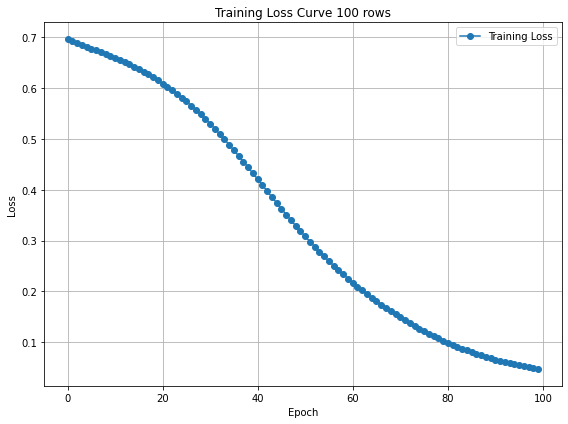

In [9]:
render_loss_plot()

### Making Predictions

In [10]:
def predict(person_id):
    # set model to evaluation mode
    model.eval()

    with torch.no_grad():
        #passes the data through the model to get the raw output (logits) for all nodes
        out = model(data)

        # print(person_idx)
        # retrieves the index of the specified person from the person_indx dictionary
        person_index = person_idx[person_id]
  
        probs = F.sigmoid(out[person_index])
        skill_probs = {skill: probs[skill_idx[skill] - len(persons)].item() for skill in skills}
        return skill_probs


def predict_top_k(person_id, k=3):
    model.eval()
    with torch.no_grad():
       # only interested in person nodes output
        out = model(data)[:num_persons]
        person_index = person_idx[person_id]
         # Apply sigmoid to get probabilities
        probs = F.sigmoid(out[person_index])
        
        actual_skills = df[df['ID'] == person_id][array_of_skills].values.flatten()
        actual_skills = [skill for skill in actual_skills if skill != "-"]
        for skill in actual_skills:
            probs[skill_idx[skill] - len(persons)] = -1 

        # Ensure that k is not greater than the number of jobs
        topk_probs, topk_indices = torch.topk(probs, k)
        topk_skills = [skills[i] for i in topk_indices]
        skill_probs = {skill: prob.item() for skill, prob in zip(topk_skills, topk_probs)}
        return skill_probs



probs = predict_top_k('C2')
print(f"Predicted skill probabilities for person 'C2':", probs)

# Create a DataFrame to store predictions
df_prediction = pd.DataFrame(columns=['ID', 'Actual Skill', 'Predicted Skill', 'Probability'])
df_prediction.index.name = 'No'

for person in persons:
    probs = predict_top_k(person)
    actual_skills = df[df['ID'] == person][array_of_skills].values.flatten()
    actual_skills = [skill for skill in actual_skills if skill != "-"]
    for skill, prob in probs.items():
        print('skill',  [skill, prob])
        if prob > 0.07:
            new_row = {'ID': person, 'Actual Skill': ', '.join(actual_skills), 'Predicted Skill': skill, 'Probability': prob}
            df_prediction = pd.concat([df_prediction, pd.DataFrame(new_row, index=[0])], ignore_index=True)

print(df_prediction)

Predicted skill probabilities for person 'C2': {'Analytical Thinking': 0.07223688066005707, 'Data Visualization': 0.06463522464036942, 'Problem Solving': 0.062261998653411865}
skill ['Time Management', 0.13936427235603333]
skill ['Analytical Thinking', 0.13633239269256592]
skill ['Leadership', 0.08607377856969833]
skill ['Analytical Thinking', 0.07223688066005707]
skill ['Data Visualization', 0.06463522464036942]
skill ['Problem Solving', 0.062261998653411865]
skill ['Adaptability', 0.0556621253490448]
skill ['Time Management', 0.05529385060071945]
skill ['Data Visualization', 0.046563077718019485]
skill ['Analytical Thinking', 0.13975468277931213]
skill ['Data Visualization', 0.12450113892555237]
skill ['Problem Solving', 0.08403971046209335]
skill ['Leadership', 0.024506518617272377]
skill ['Adaptability', 0.017306460067629814]
skill ['Data Visualization', 0.007151448167860508]
skill ['Creativity', 0.03715561330318451]
skill ['Leadership', 0.023713404312729836]
skill ['Data Visualiza

skill ['Communication', 0.10955236852169037]
skill ['Critical Thinking', 0.10360518842935562]
skill ['Data Visualization', 0.082059346139431]
skill ['Creativity', 0.03555014356970787]
skill ['Leadership', 0.016624806448817253]
skill ['Data Visualization', 0.0007710566278547049]
skill ['Analytical Thinking', 0.3085220456123352]
skill ['Time Management', 0.20811648666858673]
skill ['Team Work', 0.1474328488111496]
skill ['Time Management', 0.12922687828540802]
skill ['Leadership', 0.08506929129362106]
skill ['Adaptability', 0.05343056470155716]
skill ['Adaptability', 0.04215852916240692]
skill ['Problem Solving', 0.0414600744843483]
skill ['Analytical Thinking', 0.013974232599139214]
skill ['Leadership', 0.09377055615186691]
skill ['Creativity', 0.04768120124936104]
skill ['Communication', 0.04146234691143036]
skill ['Analytical Thinking', 0.04507799074053764]
skill ['Time Management', 0.03782902657985687]
skill ['Team Work', 0.035724468529224396]
skill ['Creativity', 0.07984817028045654

In [11]:
df_prediction

,ID,Actual Skill,Predicted Skill,Probability
0,C1,"Critical Thinking, Data Visualization, Creativity",Time Management,0.139364
1,C1,"Critical Thinking, Data Visualization, Creativity",Analytical Thinking,0.136332
2,C1,"Critical Thinking, Data Visualization, Creativity",Leadership,0.086074
3,C2,"Communication, Time Management, Team Work, Lea...",Analytical Thinking,0.072237
4,C4,"Communication, Time Management, Team Work, Lea...",Analytical Thinking,0.139755
...,...,...,...,...
102,C96,"Analytical Thinking, Team Work, Adaptability, ...",Data Visualization,0.121767
103,C98,"Critical Thinking, Data Visualization, Team Wo...",Time Management,0.072632
104,C98,"Critical Thinking, Data Visualization, Team Wo...",Analytical Thinking,0.071177
105,C100,"Critical Thinking, Team Work, Adaptability, Cr...",Data Visualization,0.073742


In [12]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

# Creating confusion matrices for each skill
all_actual_skills = df_prediction['Actual Skill'].str.get_dummies(', ')
all_predicted_skills = df_prediction['Predicted Skill'].str.get_dummies(', ')

confusion_matrices = {}
roc_aucs = {}
accuracies = []
precisions = []
recalls = []
f1_scores = []

for skill in skills:
    if skill in all_actual_skills.columns and skill in all_predicted_skills.columns:
        y_true = all_actual_skills[skill]
        y_pred = all_predicted_skills[skill]
        confusion_matrices[skill] = confusion_matrix(y_true, y_pred)
         # ROC AUC
        roc_aucs[skill] = roc_auc_score(y_true, y_pred)

        # Accuracy, Precision, Recall, F1
        accuracies.append(accuracy_score(y_true, y_pred))
        precisions.append(precision_score(y_true, y_pred))
        recalls.append(recall_score(y_true, y_pred))
        f1_scores.append(f1_score(y_true, y_pred))

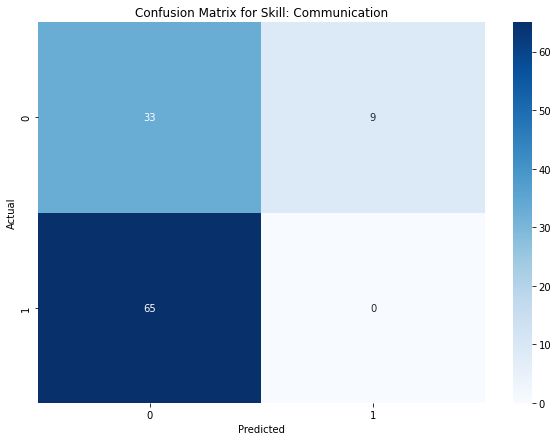

In [13]:
import seaborn as sn
# Visualizing one of the confusion matrices
skill_to_plot = skills[0]
confusion_matrix_to_plot = confusion_matrices[skill_to_plot]

fig = plt.figure(figsize=(10, 7))
sn.heatmap(confusion_matrix_to_plot, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for Skill: {skill_to_plot}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [14]:
import matplotlib.pyplot as plt

# Calculate average metrics
average_accuracy = sum(accuracies) / len(accuracies)
average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_f1_score = sum(f1_scores) / len(f1_scores)
average_roc_auc = sum(roc_aucs.values()) / len(roc_aucs)

# Print the average metrics
print(f'Average Accuracy: {average_accuracy:.2f}')
print(f'Average Precision: {average_precision:.2f}')
print(f'Average Recall: {average_recall:.2f}')
print(f'Average F1 Score: {average_f1_score:.2f}')
print(f'Average ROC AUC: {average_roc_auc:.2f}')

# # Create a bar chart
# metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
# values = [average_accuracy, average_precision, average_recall, average_f1_score, average_roc_auc]

# plt.figure(figsize=(10, 6))
# plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red', 'purple'])
# plt.ylim(0, 1)
# plt.title('Average Metrics for Multi-Label Classification')
# plt.ylabel('Scores')
# plt.xlabel('Metrics')
# for i, v in enumerate(values):
#     plt.text(i, v + 0.02, f'{v:.2f}', ha='center', fontweight='bold')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()


Average Accuracy: 0.43
Average Precision: 0.00
Average Recall: 0.00
Average F1 Score: 0.00
Average ROC AUC: 0.40


In [15]:
print('confusion_matrix_to_plot', confusion_matrix_to_plot)

confusion_matrix_to_plot [[33  9]
 [65  0]]


### Precision, Recall, Acuracies and F1 Scores

In [16]:

epochs = np.arange(1, 11)

# class_labels = confusion_matrix_to_plot.flatten()[: len(confusion_matrix_to_plot)]

def render_plot():
  datasetsize = len(df) 

  # Create the plot
  plt.plot(epochs, accuracies, label='Precision')
  plt.plot(epochs, recalls, label='Recall', color='orange')
  plt.plot(epochs, f1_scores, label='F1 Score', color='purple')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.title(f'Fig 3. Precision, Recall, F1 Score  {datasetsize} rows')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()


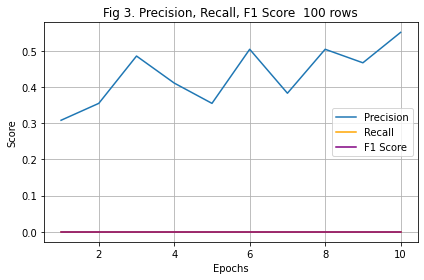

In [17]:
render_plot()

### Visualize Graph

In [18]:
# print('persons', persons)
# print('edges', edges)

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

# Define the visualize_graph function
def visualize_graph(person_id, new_edges, threshold=0.7):
    probs = predict(person_id)
    G = nx.Graph()

    # Add nodes for persons and skills
    G.add_nodes_from(persons, bipartite=0)
    G.add_nodes_from(skills, bipartite=1)

    # Add edges based on predefined relationships
    for edge in new_edges:
        if edge[0] < len(persons):
            if edge[1] >= len(persons):
                G.add_edge(list(person_idx.keys())[edge[0]], list(skill_idx.keys())[edge[1] - len(persons)])

    ##### STYLING #####
    custom_gray = '#f4f4f4'
    custom_blue = '#e6fbff'

    # Add predicted edges based on probabilities
    for job_name, prob in probs.items():
        if prob >= threshold:
            G.add_edge(person_id, job_name, color='red')
        elif prob >= 0.5 and prob < threshold:
            G.add_edge(person_id, job_name, color='blue', style='dashed', alpha=0.7)
        else:
            G.add_edge(person_id, job_name, color=custom_gray, alpha=0.7)

    # Get edge attributes for coloring and styling
    nx_edges = G.edges(data=True)
    colors = [dt['color'] if 'color' in dt else custom_blue for _, _, dt in nx_edges]
    styles = [dt['style'] if 'style' in dt else 'solid' for _, _, dt in nx_edges]

    # Create a multipartite layout
    pos = nx.multipartite_layout(G, subset_key="bipartite", align="vertical")

    # Define positions for nodes
    # Distance between layers
    x_offset = 5
    # Space between nodes within each layer
    y_spacing = 10

    # Adjust the positions to apply custom spacing
    for node, (x, y) in pos.items():
        if G.nodes[node]['bipartite'] == 0:
            pos[node] = (x, y * y_spacing)
        elif G.nodes[node]['bipartite'] == 1:
            pos[node] = (x + x_offset, y * y_spacing)

    # Define node colors based on the bipartite attribute
    node_colors = []
    for node in G.nodes():
        if G.nodes[node]['bipartite'] == 0:
            node_colors.append('lightblue')
        else:
            node_colors.append('lightgreen')

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, edge_color=colors, style=styles, node_size=5000, node_color=node_colors, font_size=10)
    plt.show()



# Example usage



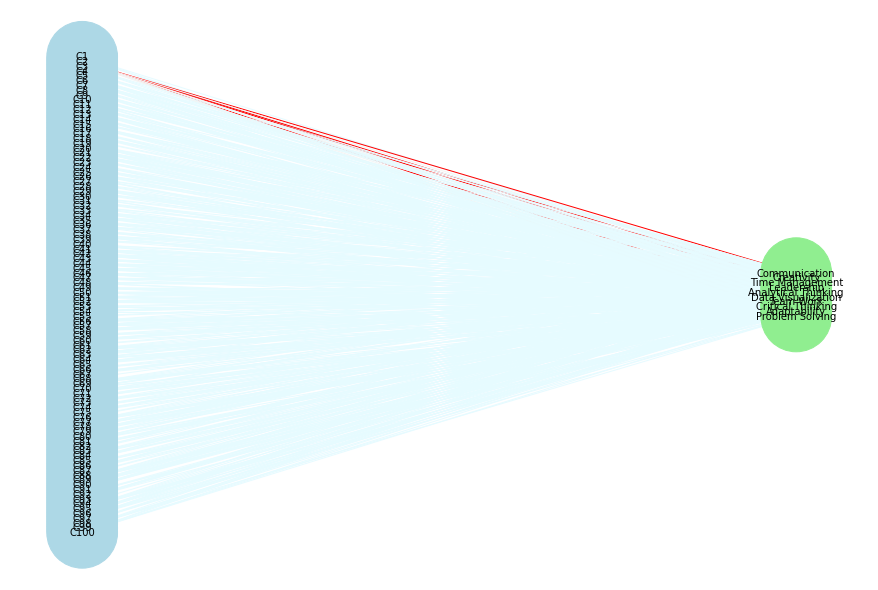

In [20]:
# Create edges based on data
new_edges = []
# Person to Skill edges
for i, row in df.iterrows():
    for skill in array_of_skills:
        if row[skill] != "-":
            new_edges.append((person_idx[row["ID"]], skill_idx[row[skill]]))

visualize_graph('C2', new_edges, threshold=0.7)